**Sriram Sunderrajan** <br>
**220962444** <br>
**Deep Learning Lab - Week 6** <br>
**Transfer Learning** <br>
**CSE - AIML (A2 - 77)** <br>
**11th February 2025** <br><br>

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import metrics
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F

## Question - 1

In [9]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

batch_size = 4
train_set = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

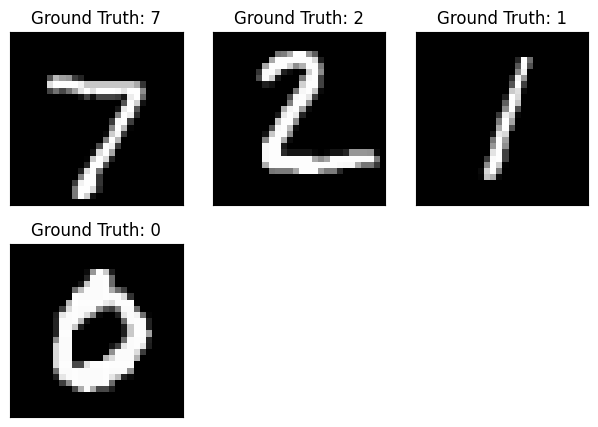

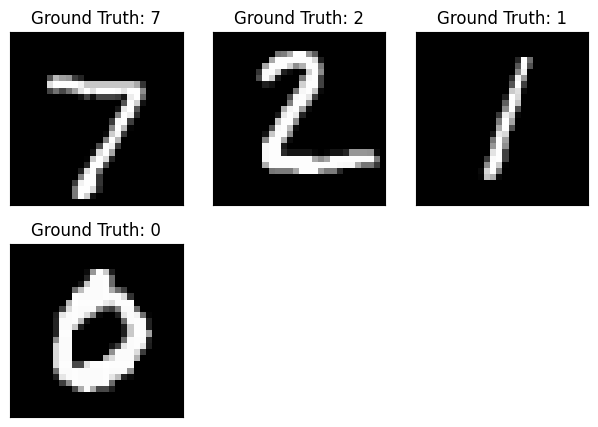

In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(4):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CNNNetwork(nn.Module):
    def __init__(self):
        super(CNNNetwork, self).__init__()
        self.feature_extractor = nn.Sequential(nn.Conv2d(1, 10, kernel_size=5),
                                              nn.MaxPool2d((2, 2), stride=None),
                                              nn.ReLU(),
                                              nn.Conv2d(10, 20, kernel_size=5),
                                              #nn.Dropout2d(),
                                              nn.MaxPool2d((2, 2), stride=None),
                                              nn.ReLU()
                                              )
        self.flatten = nn.Flatten()
        self.classification_head = nn.Sequential(nn.Linear(320, 64, bias=True),
                                                 nn.ReLU(),
                                                 nn.Linear(64, 10, bias=True))
        
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)   # x = x.view(-1, 320)
        x = self.classification_head(x)
        x = F.log_softmax(x, dim=1)
        return x
    


model = CNNNetwork().to(device)
model.train()

criterion = F.nll_loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [16]:
losses = []
num_epochs = 3
model.train()

for epoch in range(1, num_epochs+1):
    epoch_loss = 0
    for idx, (x_batch, y_batch) in enumerate(train_loader):
        batch_size = len(x_batch)
        loader_size = len(train_loader)
        
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)
        y_pred = y_pred.reshape(batch_size,-1)

        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += loss
        
        if (idx % 1000 == 0):
            progress = (idx / loader_size)
            print(f"{idx * batch_size} / {loader_size * batch_size} : Progress = {progress:.2%}")
                
    if epoch%1 == 0:
        losses.append(epoch_loss.detach().cpu())
        print(f"Epoch {epoch}: Loss = {epoch_loss}")

0 / 60000 : Progress = 0.00%
4000 / 60000 : Progress = 6.67%
8000 / 60000 : Progress = 13.33%
12000 / 60000 : Progress = 20.00%
16000 / 60000 : Progress = 26.67%
20000 / 60000 : Progress = 33.33%
24000 / 60000 : Progress = 40.00%
28000 / 60000 : Progress = 46.67%
32000 / 60000 : Progress = 53.33%
36000 / 60000 : Progress = 60.00%
40000 / 60000 : Progress = 66.67%
44000 / 60000 : Progress = 73.33%
48000 / 60000 : Progress = 80.00%
52000 / 60000 : Progress = 86.67%
56000 / 60000 : Progress = 93.33%
Epoch 1: Loss = 1775.136962890625
0 / 60000 : Progress = 0.00%
4000 / 60000 : Progress = 6.67%
8000 / 60000 : Progress = 13.33%
12000 / 60000 : Progress = 20.00%
16000 / 60000 : Progress = 26.67%
20000 / 60000 : Progress = 33.33%
24000 / 60000 : Progress = 40.00%
28000 / 60000 : Progress = 46.67%
32000 / 60000 : Progress = 53.33%
36000 / 60000 : Progress = 60.00%
40000 / 60000 : Progress = 66.67%
44000 / 60000 : Progress = 73.33%
48000 / 60000 : Progress = 80.00%
52000 / 60000 : Progress = 86.

Number of parameters: 26474


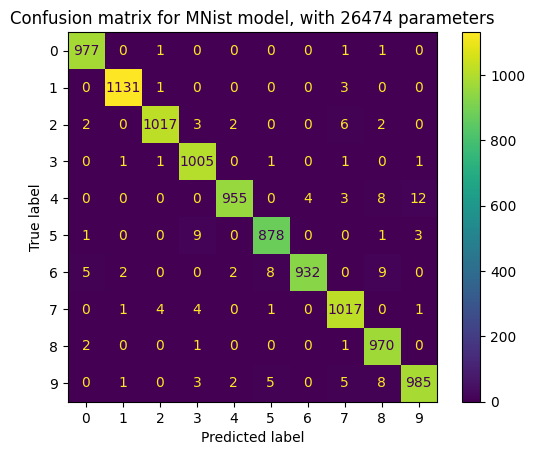

'98.67%'

In [17]:
model.eval()

losses = []
y_eval, y_preds = [], []


for x_batch, y_batch in test_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_pred = model(x_batch)
    y_pred = y_pred.argmax(dim=1)
    
    y_eval += y_batch.detach().cpu().numpy().tolist()
    y_preds += y_pred.detach().cpu().numpy().tolist()


total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

confusion_matrix = metrics.confusion_matrix(y_eval, y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

cm_display.plot()

plt.title(f"Confusion matrix for MNist model, with {total_params} parameters")
plt.show() 
   
acc1 = accuracy_score(y_preds, y_eval)    

f"{accuracy_score(y_preds, y_eval):.2%}"

In [18]:
print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
print("Optimizer's state dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state dict:
feature_extractor.0.weight 	 torch.Size([10, 1, 5, 5])
feature_extractor.0.bias 	 torch.Size([10])
feature_extractor.3.weight 	 torch.Size([20, 10, 5, 5])
feature_extractor.3.bias 	 torch.Size([20])
classification_head.0.weight 	 torch.Size([64, 320])
classification_head.0.bias 	 torch.Size([64])
classification_head.2.weight 	 torch.Size([10, 64])
classification_head.2.bias 	 torch.Size([10])
Optimizer's state dict:
state 	 {0: {'step': tensor(45000.), 'exp_avg': tensor([[[[-0.0060, -0.0069, -0.0058, -0.0043,  0.0059],
          [-0.0078, -0.0068, -0.0032,  0.0019,  0.0115],
          [-0.0106, -0.0046, -0.0007,  0.0050,  0.0099],
          [-0.0078,  0.0016,  0.0016,  0.0054,  0.0076],
          [ 0.0015,  0.0053,  0.0062,  0.0064,  0.0049]]],


        [[[-0.0046, -0.0069, -0.0082, -0.0128, -0.0054],
          [-0.0026, -0.0054, -0.0063, -0.0042, -0.0017],
          [-0.0034, -0.0018, -0.0011,  0.0064,  0.0078],
          [-0.0041,  0.0054,  0.0119,  0.0147,  0.01

In [19]:
torch.save(model, "./ModelFiles/MNISTmodel.pt")

In [21]:
torch.save(model.state_dict(), './ModelFiles/MNISTmodel.pth')

In [20]:
mnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False)

mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [27]:
model = CNNNetwork()
model = torch.load('./ModelFiles/MNISTmodel.pt')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-2)

/tmp/ipykernel_23440/3878080169.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./ModelFiles/MNISTmodel.pt')


In [28]:
print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state dict:
feature_extractor.0.weight 	 torch.Size([10, 1, 5, 5])
feature_extractor.0.bias 	 torch.Size([10])
feature_extractor.3.weight 	 torch.Size([20, 10, 5, 5])
feature_extractor.3.bias 	 torch.Size([20])
classification_head.0.weight 	 torch.Size([64, 320])
classification_head.0.bias 	 torch.Size([64])
classification_head.2.weight 	 torch.Size([10, 64])
classification_head.2.bias 	 torch.Size([10])


### Evaluation of FashionMNIST: Before transfer learning

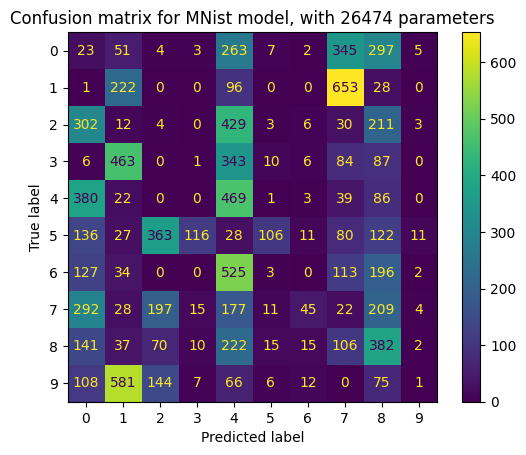

'12.30%'

In [29]:
model.eval()

losses = []
y_eval, y_preds = [], []


for x_batch, y_batch in test_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_pred = model(x_batch)
    y_pred = y_pred.argmax(dim=1)
    
    y_eval += y_batch.detach().cpu().numpy().tolist()
    y_preds += y_pred.detach().cpu().numpy().tolist()


confusion_matrix = metrics.confusion_matrix(y_eval, y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

cm_display.plot()

plt.title(f"Confusion matrix for MNist model, with {total_params} parameters")
plt.show() 
   
acc1 = accuracy_score(y_preds, y_eval)    

f"{accuracy_score(y_preds, y_eval):.2%}"

### Transfer learning

In [30]:
losses = []
num_epochs = 5
model.train()

for epoch in range(1, num_epochs+1):
    epoch_loss = 0
    for idx, (x_batch, y_batch) in enumerate(train_loader):
        batch_size = len(x_batch)
        loader_size = len(train_loader)
        
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)
        y_pred = y_pred.reshape(batch_size,-1)

        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += loss
        
        if (idx % 1000 == 0):
            progress = (idx / loader_size)
            print(f"{idx * batch_size} / {loader_size * batch_size} : Progress = {progress:.2%}")
                
    if epoch%1 == 0:
        losses.append(epoch_loss.detach().cpu())
        print(f"Epoch {epoch}: Loss = {epoch_loss}")

0 / 60000 : Progress = 0.00%
4000 / 60000 : Progress = 6.67%
8000 / 60000 : Progress = 13.33%
12000 / 60000 : Progress = 20.00%
16000 / 60000 : Progress = 26.67%
20000 / 60000 : Progress = 33.33%
24000 / 60000 : Progress = 40.00%
28000 / 60000 : Progress = 46.67%
32000 / 60000 : Progress = 53.33%
36000 / 60000 : Progress = 60.00%
40000 / 60000 : Progress = 66.67%
44000 / 60000 : Progress = 73.33%
48000 / 60000 : Progress = 80.00%
52000 / 60000 : Progress = 86.67%
56000 / 60000 : Progress = 93.33%
Epoch 1: Loss = 11097.8583984375
0 / 60000 : Progress = 0.00%
4000 / 60000 : Progress = 6.67%
8000 / 60000 : Progress = 13.33%
12000 / 60000 : Progress = 20.00%
16000 / 60000 : Progress = 26.67%
20000 / 60000 : Progress = 33.33%
24000 / 60000 : Progress = 40.00%
28000 / 60000 : Progress = 46.67%
32000 / 60000 : Progress = 53.33%
36000 / 60000 : Progress = 60.00%
40000 / 60000 : Progress = 66.67%
44000 / 60000 : Progress = 73.33%
48000 / 60000 : Progress = 80.00%
52000 / 60000 : Progress = 86.6

### Evaluation of FashionMNIST: After transfer learning

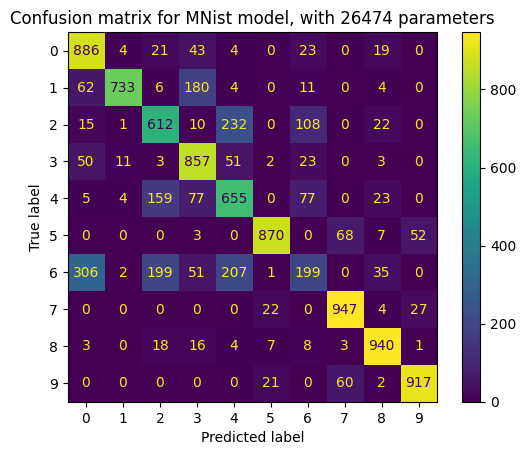

'76.16%'

In [31]:
model.eval()

losses = []
y_eval, y_preds = [], []


for x_batch, y_batch in test_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_pred = model(x_batch)
    y_pred = y_pred.argmax(dim=1)
    
    y_eval += y_batch.detach().cpu().numpy().tolist()
    y_preds += y_pred.detach().cpu().numpy().tolist()


confusion_matrix = metrics.confusion_matrix(y_eval, y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

cm_display.plot()

plt.title(f"Confusion matrix for MNist model, with {total_params} parameters")
plt.show() 
   
acc1 = accuracy_score(y_preds, y_eval)    

f"{accuracy_score(y_preds, y_eval):.2%}"

In [33]:
torch.save(model.state_dict(), './ModelFiles/MNISTFashionModel.pth')

## Question - 2

In [35]:
import os
from PIL import Image

In [36]:
class imgDataset(Dataset):
    def __init__(self, dir="./data/cats_and_dogs_filtered/train/"):
        cats_dir = os.path.join(dir, "cats/")
        dogs_dir = os.path.join(dir, "dogs/")
        self.x = [os.path.join(cats_dir, f) for f in os.listdir(cats_dir) if f.endswith(".jpg")] + [os.path.join(dogs_dir, f) for f in os.listdir(dogs_dir) if f.endswith(".jpg")]
        self.y = [0 for f in os.listdir(cats_dir) if f.endswith(".jpg")] + [1 for f in os.listdir(dogs_dir) if f.endswith(".jpg")]
        self.y = torch.tensor(self.y)
        self.transform = transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = Image.open(self.x[idx]).convert('RGB')
        tensor = self.transform(img)
        return tensor.to(device), self.y[idx].to(device)

In [54]:
batch_size = 4
train_set = imgDataset()
val_set = imgDataset(dir="./data/cats_and_dogs_filtered/validation/")

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [38]:
len([f for f in os.listdir("./data/cats_and_dogs_filtered/train/cats") if f.endswith(".jpg")] + [f for f in os.listdir("./data/cats_and_dogs_filtered/train/dogs") if f.endswith(".jpg")])

2000

In [42]:
from torchvision.models import AlexNet_Weights

#model = torch.hub.load('pytorch/vision:v0.10.0', model='alexnet', weights=AlexNet_Weights.DEFAULT)
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Using cache found in /home/student/.cache/torch/hub/pytorch_vision_v0.10.0
/home/student/Documents/220962262/DL_lab/dl_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/Documents/220962262/DL_lab/dl_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
for idx, (x_batch, y_batch) in enumerate(train_loader):
    with torch.no_grad():
        output = model(x_batch)
    # Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
    print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    print(probabilities)
    break

tensor([-0.1906, -1.7544], device='cuda:0')
tensor([0.8269, 0.1731], device='cuda:0')


In [67]:
NUM_EPOCHS = 5
losses = []
model.train()

for epoch in range(1, NUM_EPOCHS+1):
    epoch_loss = 0
    for idx, (x_batch, y_batch) in enumerate(train_loader):
        batch_size = y_batch.shape[0]
        loader_size = len(train_loader)
        output = model(x_batch)
        y_pred = torch.nn.functional.softmax(output, dim=1)

        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += loss
        
        if (idx % 200 == 0):
            progress = (idx / loader_size)
            print(f"{idx * batch_size} / {loader_size * batch_size} : Progress = {progress:.2%}")
                
    if epoch%1 == 0:
        losses.append(epoch_loss.detach().cpu())
        print(f"Epoch {epoch}: Loss = {epoch_loss}")

0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 1: Loss = 159.25540161132812
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 2: Loss = 159.86279296875
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 3: Loss = 159.09375
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 4: Loss = 160.09054565429688
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 5: Loss = 159.2582550048828
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 6: Loss = 158.89503479003906
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 7: Loss = 158.8028106689453
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 8: Loss = 158.9846649169922
0 / 200

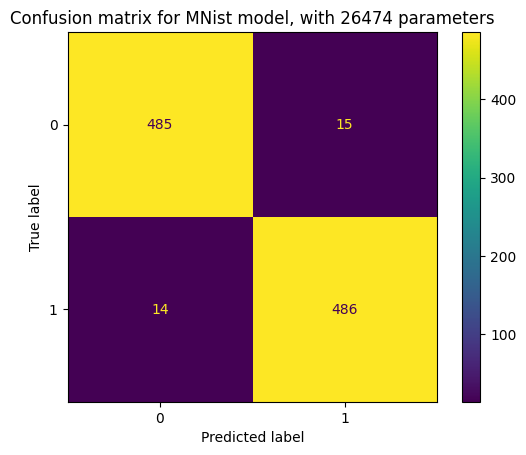

'97.10%'

In [68]:
model.eval()

losses = []
y_eval, y_preds = [], []


for x_batch, y_batch in val_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    output = model(x_batch)
    y_pred = F.softmax(output, dim=1)
    y_pred = y_pred.argmax(dim=1)
    
    y_eval += y_batch.detach().cpu().numpy().tolist()
    y_preds += y_pred.detach().cpu().numpy().tolist()


confusion_matrix = metrics.confusion_matrix(y_eval, y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()

plt.title(f"Confusion matrix for MNist model, with {total_params} parameters")
plt.show() 
   
acc1 = accuracy_score(y_preds, y_eval)    

f"{accuracy_score(y_preds, y_eval):.2%}"

In [ ]:
torch.save({'epoch': NUM_EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss},
           './ModelFiles/CustomAlex_1.pth')

## Question - 3

### Load checkpoint

In [80]:
CHECKPOINT_PATH = './ModelFiles/CustomAlex_1.pth'

model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)

optimizer = optim.SGD(model.parameters(), lr=1e-3)


checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.to(device)

Using cache found in /home/student/.cache/torch/hub/pytorch_vision_v0.10.0
/home/student/Documents/220962262/DL_lab/dl_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/Documents/220962262/DL_lab/dl_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_23440/3022034270.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURI

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
NUM_EPOCHS = 15
losses = []
model.train()

for epoch in range(epoch+1, epoch+NUM_EPOCHS+1):
    epoch_loss = 0
    for idx, (x_batch, y_batch) in enumerate(train_loader):
        batch_size = y_batch.shape[0]
        loader_size = len(train_loader)
        output = model(x_batch)
        y_pred = torch.nn.functional.softmax(output, dim=1)

        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += loss
        
        if (idx % 200 == 0):
            progress = (idx / loader_size)
            print(f"{idx * batch_size} / {loader_size * batch_size} : Progress = {progress:.2%}")
                
    if epoch%1 == 0:
        losses.append(epoch_loss.detach().cpu())
        print(f"Epoch {epoch}: Loss = {epoch_loss}")

0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%


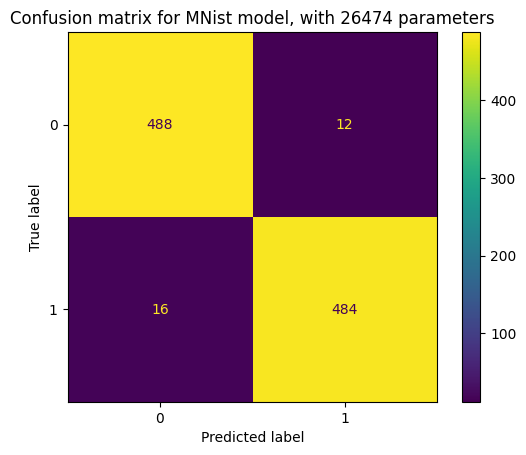

'97.20%'

In [78]:
model.eval()

losses = []
y_eval, y_preds = [], []


for x_batch, y_batch in val_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    output = model(x_batch)
    y_pred = F.softmax(output, dim=1)
    y_pred = y_pred.argmax(dim=1)
    
    y_eval += y_batch.detach().cpu().numpy().tolist()
    y_preds += y_pred.detach().cpu().numpy().tolist()


confusion_matrix = metrics.confusion_matrix(y_eval, y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()

plt.title(f"Confusion matrix for MNist model, with {total_params} parameters")
plt.show() 
   
acc1 = accuracy_score(y_preds, y_eval)    

f"{accuracy_score(y_preds, y_eval):.2%}"

### Save checkpoint

In [79]:
torch.save({'epoch': NUM_EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss},
           './ModelFiles/CustomAlex_2.pth')